In [3]:
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from collections import Counter

warnings.filterwarnings("ignore")
NUM_WORKERS = 4

In [4]:
DATA_PATH = "/kaggle/input/ventilator-pressure-prediction/"

sub = pd.read_csv(DATA_PATH + 'sample_submission.csv')
df_train = pd.read_csv(DATA_PATH + 'train.csv')
df_test = pd.read_csv(DATA_PATH + 'test.csv')

In [5]:
print(len(df_train))
df_train[20:40]

6036000


,id,breath_id,R,C,time_step,u_in,u_out,pressure
20,21,1,20,50,0.680176,20.701046,0,19.335504
21,22,1,20,50,0.715327,20.843610,0,18.491878
22,23,1,20,50,0.749344,20.269191,0,18.562180
23,24,1,20,50,0.783241,19.693681,0,18.632482
24,25,1,20,50,0.817397,18.927285,0,18.843389
25,26,1,20,50,0.851411,18.093826,0,19.054295
26,27,1,20,50,0.885488,17.193955,0,19.265201
27,28,1,20,50,0.919468,16.419253,0,19.335504
28,29,1,20,50,0.953547,15.744684,0,19.335504
29,30,1,20,50,0.987487,14.931596,0,19.476108


In [6]:
df_test.head()

,id,breath_id,R,C,time_step,u_in,u_out
0,1,0,5,20,0.000000,0.000000,0
1,2,0,5,20,0.031904,7.515046,0
2,3,0,5,20,0.063827,14.651675,0
3,4,0,5,20,0.095751,21.230610,0
4,5,0,5,20,0.127644,26.320956,0


In [7]:
df_train["breath_id"].unique()

array([     1,      2,      3, ..., 125743, 125745, 125749])

In [6]:
def plot_data(df, breath_id):
    df_breath = df[df["breath_id"] == breath_id]
    r, c = df_breath[["R", "C"]].values[0]
    plt.figure(figsize=(12, 4))
    for col in ["u_in", "u_out", "pressure"]:
        plt.plot(df_breath['time_step'], df_breath[col], label=col)
    plt.legend()
    plt.title(f'breath_id: {breath_id} R: {r} C: {c}')

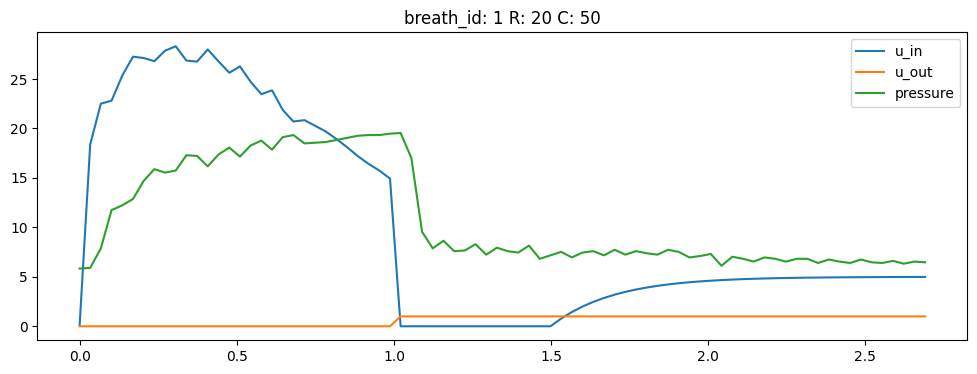

In [7]:
plot_data(df_train , 1)

In [8]:
import torch
from torch.utils.data import Dataset

class VentilatorDataset(Dataset):
    def __init__(self, df):
        super().__init__()
        if "pressure" not in df.columns:
            df['pressure'] = 0
        self.df = df.groupby("breath_id").agg(list).reset_index()
        self.prepare_data()

    def __len__(self):
        return self.df.shape[0]
        
    def prepare_data(self):
        self.pressures = np.array(self.df['pressure'].values.tolist())
        rs = np.array(self.df['R'].values.tolist())
        cs = np.array(self.df['C'].values.tolist())
        u_ins = np.array(self.df['u_in'].values.tolist())
        self.u_outs = np.array(self.df['u_out'].values.tolist())
        
        self.inputs = np.concatenate([
            rs[:, None], 
            cs[:, None], 
            u_ins[:, None], 
            np.cumsum(u_ins, 1)[:, None],
            self.u_outs[:, None]
        ], 1).transpose(0, 2, 1)

    def __getitem__(self, idx):
        data = {
            "input": torch.tensor(self.inputs[idx], dtype=torch.float),
            "u_out": torch.tensor(self.u_outs[idx], dtype=torch.float),
            "p": torch.tensor(self.pressures[idx], dtype=torch.float),
        }
        
        return data

In [9]:
dataset = VentilatorDataset(df_train)
print(dataset[0]["input"].shape)
dataset[0]

torch.Size([80, 5])


{'input': tensor([[2.0000e+01, 5.0000e+01, 8.3334e-02, 8.3334e-02, 0.0000e+00],
         [2.0000e+01, 5.0000e+01, 1.8383e+01, 1.8466e+01, 0.0000e+00],
         [2.0000e+01, 5.0000e+01, 2.2509e+01, 4.0976e+01, 0.0000e+00],
         [2.0000e+01, 5.0000e+01, 2.2809e+01, 6.3784e+01, 0.0000e+00],
         [2.0000e+01, 5.0000e+01, 2.5356e+01, 8.9140e+01, 0.0000e+00],
         [2.0000e+01, 5.0000e+01, 2.7260e+01, 1.1640e+02, 0.0000e+00],
         [2.0000e+01, 5.0000e+01, 2.7127e+01, 1.4353e+02, 0.0000e+00],
         [2.0000e+01, 5.0000e+01, 2.6808e+01, 1.7034e+02, 0.0000e+00],
         [2.0000e+01, 5.0000e+01, 2.7865e+01, 1.9820e+02, 0.0000e+00],
         [2.0000e+01, 5.0000e+01, 2.8313e+01, 2.2651e+02, 0.0000e+00],
         [2.0000e+01, 5.0000e+01, 2.6867e+01, 2.5338e+02, 0.0000e+00],
         [2.0000e+01, 5.0000e+01, 2.6763e+01, 2.8014e+02, 0.0000e+00],
         [2.0000e+01, 5.0000e+01, 2.7993e+01, 3.0814e+02, 0.0000e+00],
         [2.0000e+01, 5.0000e+01, 2.6790e+01, 3.3493e+02, 0.0000e+00

In [10]:
a = [np.arange(10)]
b = [np.arange(10) * 2] 
c = [np.arange(10) * 3]
d = [np.arange(10) * 4]

print(a)
e = np.concatenate([
    a,b,c,d
],0)
e

[array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])]


array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
       [ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18],
       [ 0,  3,  6,  9, 12, 15, 18, 21, 24, 27],
       [ 0,  4,  8, 12, 16, 20, 24, 28, 32, 36]])

In [11]:
e.transpose(1, 0)

array([[ 0,  0,  0,  0],
       [ 1,  2,  3,  4],
       [ 2,  4,  6,  8],
       [ 3,  6,  9, 12],
       [ 4,  8, 12, 16],
       [ 5, 10, 15, 20],
       [ 6, 12, 18, 24],
       [ 7, 14, 21, 28],
       [ 8, 16, 24, 32],
       [ 9, 18, 27, 36]])

# LSTM

In [41]:
import torch
import torch.nn as nn
import math


class LSTM(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.output_dim = output_dim
        # Update gate
        self.w_ux = nn.Parameter(torch.Tensor(input_dim, output_dim)) 
        self.w_ua = nn.Parameter(torch.Tensor(output_dim, output_dim)) 
        self.b_u = nn.Parameter(torch.Tensor(1, output_dim))

        # Forget gate
        self.w_fx = nn.Parameter(torch.Tensor(input_dim, output_dim)) 
        self.w_fa = nn.Parameter(torch.Tensor(output_dim, output_dim)) 
        self.b_f = nn.Parameter(torch.Tensor(1, output_dim))

        # Output gate
        self.w_ox = nn.Parameter(torch.Tensor(input_dim, output_dim)) 
        self.w_oa = nn.Parameter(torch.Tensor(output_dim, output_dim)) 
        self.b_o = nn.Parameter(torch.Tensor(1,output_dim))

        # Potential next candidate
        self.w_cx = nn.Parameter(torch.Tensor(input_dim, output_dim)) 
        self.w_ca = nn.Parameter(torch.Tensor(output_dim, output_dim)) 
        self.b_c = nn.Parameter(torch.Tensor(1,output_dim))

        # Initialize parameters for better performance
        self.reset_parameters()

    def reset_parameters(self):
        # A common way to initialize weights, similar to what nn.Linear does
        stdv = 1.0 / math.sqrt(self.output_dim)
        for weight in self.parameters():
            nn.init.uniform_(weight, -stdv, stdv)

    def forward(self, X):
        batch, examples, dim = X.shape
        seq_len = examples
        hidden_candidate_state = torch.zeros((batch, seq_len, self.output_dim)).to("cuda" if torch.cuda.is_available() else "cpu")
        hidden_activation_state = torch.zeros((batch, seq_len, self.output_dim)).to("cuda" if torch.cuda.is_available() else "cpu")
        curr_candidate = torch.zeros((batch, 1, self.output_dim)).to("cuda" if torch.cuda.is_available() else "cpu")
        curr_activation = torch.zeros((batch, 1, self.output_dim)).to("cuda" if torch.cuda.is_available() else "cpu")
        for i in range(seq_len):
            curr_input = X[:, i:i+1, :]
            update_gate = torch.sigmoid((curr_input @ self.w_ux) + (curr_activation @ self.w_ua) + self.b_u)
            output_gate = torch.sigmoid((curr_input @ self.w_ox) + (curr_activation @ self.w_oa) + self.b_o)
            forget_gate = torch.sigmoid((curr_input @ self.w_fx) + (curr_activation @ self.w_fa) + self.b_f)
            potential_new_candidate = torch.tanh((curr_input @ self.w_cx) + (curr_activation @ self.w_ca) + self.b_u)
            next_candidate = (update_gate * potential_new_candidate) + (forget_gate * curr_candidate)
            next_activation = output_gate * torch.tanh(next_candidate)
            hidden_candidate_state[:,i, :] = next_candidate.squeeze(1)
            hidden_activation_state[:, i, :] = next_activation.squeeze(1)
            curr_candidate = next_candidate
            curr_activation = next_activation

        return hidden_activation_state

In [42]:
lstm = LSTM(10, 20).to("cuda" if torch.cuda.is_available() else "cpu")
a = torch.randn(128, 5,10).to("cuda" if torch.cuda.is_available() else "cpu")
lstm(a).shape

torch.Size([128, 5, 20])

In [36]:
class RNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = 256
        self.block = nn.Sequential(
            nn.Linear(input_dim, self.hidden_dim//2),
            nn.ReLU(),
            nn.Linear(self.hidden_dim//2, self.hidden_dim),
            nn.ReLU(), 
            LSTM(self.hidden_dim, self.hidden_dim),
            nn.Linear(self.hidden_dim, output_dim)
        )

    def forward(self, X):
        return self.block(X)

In [43]:
rnn = RNN(10, 1).to("cuda" if torch.cuda.is_available() else "cpu")
a = torch.randn(10, 5,10).to("cuda" if torch.cuda.is_available() else "cpu")
rnn(a).shape

torch.Size([10, 5, 1])

In [17]:
import os
import torch
import random
import numpy as np


def seed_everything(seed):
    """
    Seeds basic parameters for reproductibility of results.

    Args:
        seed (int): Number of the seed.
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    
def count_parameters(model, all=False):
    """
    Counts the parameters of a model.

    Args:
        model (torch model): Model to count the parameters of.
        all (bool, optional):  Whether to count not trainable parameters. Defaults to False.

    Returns:
        int: Number of parameters.
    """
    if all:
        return sum(p.numel() for p in model.parameters())
    else:
        return sum(p.numel() for p in model.parameters() if p.requires_grad)

    
def worker_init_fn(worker_id):
    """
    Handles PyTorch x Numpy seeding issues.

    Args:
        worker_id (int): Id of the worker.
    """
    np.random.seed(np.random.get_state()[1][0] + worker_id)
    

def save_model_weights(model, filename, verbose=1, cp_folder=""):
    """
    Saves the weights of a PyTorch model.

    Args:
        model (torch model): Model to save the weights of.
        filename (str): Name of the checkpoint.
        verbose (int, optional): Whether to display infos. Defaults to 1.
        cp_folder (str, optional): Folder to save to. Defaults to "".
    """
    if verbose:
        print(f"\n -> Saving weights to {os.path.join(cp_folder, filename)}\n")
    torch.save(model.state_dict(), os.path.join(cp_folder, filename))

In [18]:
def compute_metric(df, preds):
    """
    Metric for the problem, as I understood it.
    """
    
    y = np.array(df['pressure'].values.tolist())
    w = 1 - np.array(df['u_out'].values.tolist())
    
    assert y.shape == preds.shape and w.shape == y.shape, (y.shape, preds.shape, w.shape)
    
    mae = w * np.abs(y - preds)
    mae = mae.sum() / w.sum()
    
    return mae


class VentilatorLoss(nn.Module):
    """
    Directly optimizes the competition metric
    """
    def __call__(self, preds, y, u_out):
        w = 1 - u_out
        mae = w * (y - preds).abs()
        mae = mae.sum(-1) / w.sum(-1)

        return mae

In [19]:
def predict(
    model,
    dataset,
    batch_size=64,
    device="cuda"
):
    """
    Usual torch predict function. Supports sigmoid and softmax activations.
    Args:
        model (torch model): Model to predict with.
        dataset (PathologyDataset): Dataset to predict on.
        batch_size (int, optional): Batch size. Defaults to 64.
        device (str, optional): Device for torch. Defaults to "cuda".

    Returns:
        numpy array [len(dataset) x num_classes]: Predictions.
    """
    model.eval()

    loader = DataLoader(
        dataset, batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS
    )
    
    preds = []
    with torch.no_grad():
        for data in loader:
            pred = model(data['input'].to(device)).squeeze(-1)
            preds.append(pred.detach().cpu().numpy())

    preds = np.concatenate(preds, 0)
    return preds

In [9]:
import gc
import time
import torch
import numpy as np
from torch.utils.data import DataLoader
from transformers import get_linear_schedule_with_warmup


def fit(
    model,
    train_dataset,
    val_dataset,
    loss_name="L1Loss",
    optimizer="Adam",
    epochs=50,
    batch_size=32,
    val_bs=32,
    warmup_prop=0.1,
    lr=1e-3,
    num_classes=1,
    verbose=1,
    first_epoch_eval=0,
    device="cuda"
):
    avg_val_loss = 0.

    # Optimizer
    optimizer = getattr(torch.optim, optimizer)(model.parameters(), lr=lr)

    # Data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
        num_workers=NUM_WORKERS,
        pin_memory=True,
        worker_init_fn=worker_init_fn
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=val_bs,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=True,
    )

    # Loss
#     loss_fct = getattr(torch.nn, loss_name)(reduction="none")
    loss_fct = VentilatorLoss()

    # Scheduler
    num_warmup_steps = int(warmup_prop * epochs * len(train_loader))
    num_training_steps = int(epochs * len(train_loader))
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps, num_training_steps
    )

    for epoch in range(epochs):
        model.train()
        model.zero_grad()
        start_time = time.time()

        avg_loss = 0
        for data in train_loader:
            pred = model(data['input'].to(device)).squeeze(-1)

            loss = loss_fct(
                pred,
                data['p'].to(device),
                data['u_out'].to(device),
            ).mean()
            loss.backward()
            avg_loss += loss.item() / len(train_loader)

            optimizer.step()
            scheduler.step()

            for param in model.parameters():
                param.grad = None

        model.eval()
        mae, avg_val_loss = 0, 0
        preds = []

        with torch.no_grad():
            for data in val_loader:
                pred = model(data['input'].to(device)).squeeze(-1)

                loss = loss_fct(
                    pred.detach(), 
                    data['p'].to(device),
                    data['u_out'].to(device),
                ).mean()
                avg_val_loss += loss.item() / len(val_loader)

                preds.append(pred.detach().cpu().numpy())
        
        preds = np.concatenate(preds, 0)
        mae = compute_metric(val_dataset.df, preds)

        elapsed_time = time.time() - start_time
        if (epoch + 1) % verbose == 0:
            elapsed_time = elapsed_time * verbose
            lr = scheduler.get_last_lr()[0]
            print(
                f"Epoch {epoch + 1:02d}/{epochs:02d} \t lr={lr:.1e}\t t={elapsed_time:.0f}s \t"
                f"loss={avg_loss:.3f}",
                end="\t",
            )

            if (epoch + 1 >= first_epoch_eval) or (epoch + 1 == epochs):
                print(f"val_loss={avg_val_loss:.3f}\tmae={mae:.3f}")
            else:
                print("")

    del (val_loader, train_loader, loss, data, pred)
    gc.collect()
    torch.cuda.empty_cache()

    return preds

In [24]:
def train(config, df_train, df_val, df_test, fold):
    """
    Trains and validate a model.
    """

    seed_everything(config.seed)

    model = RNN(
        input_dim=config.input_dim,
        output_dim=config.output_dim,
    ).to(config.device)
    model.zero_grad()

    train_dataset = VentilatorDataset(df_train)
    val_dataset = VentilatorDataset(df_val)
    test_dataset = VentilatorDataset(df_test)

    n_parameters = count_parameters(model)

    print(f"    -> {len(train_dataset)} training breathes")
    print(f"    -> {len(val_dataset)} validation breathes")
    print(f"    -> {n_parameters} trainable parameters\n")

    pred_val = fit(
        model,
        train_dataset,
        val_dataset,
        loss_name=config.loss,
        optimizer=config.optimizer,
        epochs=config.epochs,
        batch_size=config.batch_size,
        val_bs=config.val_bs,
        lr=config.lr,
        warmup_prop=config.warmup_prop,
        verbose=config.verbose,
        first_epoch_eval=config.first_epoch_eval,
        device=config.device,
    )
    
    pred_test = predict(
        model, 
        test_dataset, 
        batch_size=config.val_bs, 
        device=config.device
    )

    if config.save_weights:
        save_model_weights(
            model,
            f"{config.selected_model}_{fold}.pt",
            cp_folder="",
        )

    del (model, train_dataset, val_dataset, test_dataset)
    gc.collect()
    torch.cuda.empty_cache()

    return pred_val, pred_test

In [25]:
from sklearn.model_selection import GroupKFold

def k_fold(config, df, df_test):
    """
    Performs a patient grouped k-fold cross validation.
    """

    pred_oof = np.zeros(len(df))
    preds_test = []
    
    gkf = GroupKFold(n_splits=config.k)
    splits = list(gkf.split(X=df, y=df, groups=df["breath_id"]))

    for i, (train_idx, val_idx) in enumerate(splits):
        if i in config.selected_folds:
            print(f"\n-------------   Fold {i + 1} / {config.k}  -------------\n")

            df_train = df.iloc[train_idx].copy().reset_index(drop=True)
            df_val = df.iloc[val_idx].copy().reset_index(drop=True)

            pred_val, pred_test = train(config, df_train, df_val, df_test, i)
            
            pred_oof[val_idx] = pred_val.flatten()
            preds_test.append(pred_test.flatten())

    print(f'\n -> CV MAE : {compute_metric(df, pred_oof) :.3f}')

    return pred_oof, np.mean(preds_test, 0)

In [ ]:
class Config:
    """
    Parameters used for training
    """
    # General
    seed = 42
    verbose = 1
    device = "cuda" if torch.cuda.is_available() else "cpu"
    save_weights = True

    # k-fold
    k = 5
    selected_folds = [0, 1, 2, 3, 4]
    
    # Model
    selected_model = 'rnn'
    input_dim = 5
    output_dim = 1

    # Training
    loss = "L1Loss"  # not used
    optimizer = "Adam"
    batch_size = 128
    epochs = 200

    lr = 1e-3
    warmup_prop = 0

    val_bs = 256
    first_epoch_eval = 0


pred_oof, pred_test = k_fold(
    Config, 
    df_train,
    df_test,
)


-------------   Fold 1 / 5  -------------

    -> 60360 training breathes
    -> 15090 validation breathes
    -> 559361 trainable parameters

Epoch 01/200 	 lr=1.0e-03	 t=77s 	loss=3.703	val_loss=1.771	mae=1.780
Epoch 02/200 	 lr=9.9e-04	 t=75s 	loss=1.525	val_loss=1.358	mae=1.365
Epoch 03/200 	 lr=9.8e-04	 t=76s 	loss=1.288	val_loss=1.198	mae=1.204
Epoch 04/200 	 lr=9.8e-04	 t=76s 	loss=1.188	val_loss=1.121	mae=1.126
Epoch 05/200 	 lr=9.7e-04	 t=76s 	loss=1.110	val_loss=1.074	mae=1.078
Epoch 06/200 	 lr=9.7e-04	 t=76s 	loss=1.072	val_loss=1.036	mae=1.038
Epoch 07/200 	 lr=9.7e-04	 t=76s 	loss=1.027	val_loss=0.999	mae=1.003
Epoch 08/200 	 lr=9.6e-04	 t=80s 	loss=1.011	val_loss=1.005	mae=1.008
Epoch 09/200 	 lr=9.6e-04	 t=76s 	loss=0.982	val_loss=1.005	mae=1.008
Epoch 10/200 	 lr=9.5e-04	 t=76s 	loss=0.958	val_loss=0.973	mae=0.977
Epoch 11/200 	 lr=9.4e-04	 t=76s 	loss=0.936	val_loss=0.927	mae=0.930
Epoch 12/200 	 lr=9.4e-04	 t=76s 	loss=0.921	val_loss=0.920	mae=0.922
Epoch 13/200 	 l

In [ ]:
checkpoint = torch.load("/kaggle/working/rnn_0.pt")
model = RNN(5, 1)
model.load_state_dict(checkpoint['model_state_dict'])

In [ ]:
def plot_prediction(sample_id, df):
    df_breath = df[df['breath_id'] == sample_id]

    cols = ['u_in', 'u_out', 'pressure'] if 'pressure' in df.columns else ['u_in', 'u_out']
    
    plt.figure(figsize=(12, 4))
    for col in ['pred', 'pressure', 'u_out']:
        plt.plot(df_breath['time_step'], df_breath[col], label=col)
        
    metric = compute_metric(df_breath, df_breath['pred'])
        
    plt.legend()
    plt.title(f'Sample {sample_id} - MAE={metric:.3f}')

In [ ]:
df_train["pred"] = pred_oof
for i in df_train['breath_id'].unique()[:5]:
    plot_prediction(i, df_train)

In [ ]:
sub['pressure'] = pred_test
sub.to_csv('submission.csv', index=False)